# Increasing Diversity

## Initlalize DB

In [1]:
%reload_ext sql
%run lib.py

%sql postgresql+psycopg2://postgres:@127.0.0.1:5432/fcrec

## Set Test User and Generate Candidates

In [21]:
user_no = '++MXKfwkOw4VFn9HkVCRrw=='

rec_size = 20

max_cand_size = 100

query = f'''
	with rec as (
		select b.b_item_no, sum(a.time_weight * b.sim) score
		from (
			select item_no, pow(0.9, (date_part('day', to_timestamp('2021-07-25', 'YYYY-MM-DD') - event_timestamp) * 24 + date_part('hour', to_timestamp('2021-07-25', 'YYYY-MM-DD') - event_timestamp))/12) time_weight 
			from cmc_event 
			where user_no = '{user_no}'
				and event_timestamp between '2021-07-18' and '2021-07-25'
			order by event_timestamp desc
			limit 10
			) a 
			join 
			(
			select a_item_no, b_item_no, sim
			from (
				select a_item_no, b_item_no, sim, row_number() over (partition by a_item_no order by sim desc) rank
				from (
					select a.item_no a_item_no, b.item_no b_item_no, sum(a.w * b.w) sim
					from cmc_session_product_click_w a 
						join cmc_session_product_click_w b on a.session_id = b.session_id and a.item_no != b.item_no 
					where a.item_no in (
						select item_no
						from cmc_event 
						where user_no = '{user_no}'
							and event_timestamp between '2021-07-18' and '2021-07-25'
						order by event_timestamp desc
						limit 10 )
					group by a.item_no, b.item_no ) t
				) t
			where rank <= 20
			) as b on a.item_no = b.a_item_no
		group by b.b_item_no
		order by score desc
		limit {max_cand_size} )
	select a.score, b.*
	from rec a join cmc_product b on a.b_item_no = b.item_no
	order by score desc;
	'''

rec_cands = executeQuery(query)

# 통채우기

## Check Category 2 Distribution

In [5]:
query = f'''
    with history as (
        select 
            b.category2_name,
            case 
                when event_name = 'purchase_success' then 4
                when event_name = 'add_to_cart' then 3
                when event_name = 'like_item' then 2
                else 1
            end event_weight,
            pow(0.9, (date_part('day', to_timestamp('2021-07-25', 'YYYY-MM-DD') - event_timestamp) * 24 + date_part('hour', to_timestamp('2021-07-25', 'YYYY-MM-DD') - event_timestamp))/12) time_weight 
        from cmc_event a join cmc_product b on b.item_no = a.item_no 
        where user_no = '{user_no}'
            and event_timestamp between '2021-07-18' and '2021-07-25' )
    select category2_name, sum(event_weight*time_weight) weight, count(*) cnt
    from history
    group by category2_name
    order by weight desc
    '''

result = executeQuery(query)

import pandas as pd

df = pd.DataFrame(result)
df

,category2_name,weight,cnt
0,상의,4.636059,13
1,모자,3.046864,4
2,주얼리,2.615619,6
3,원피스/점프수트,1.282141,5
4,아우터,0.512856,2
5,하의,0.489249,2
6,가방,0.461571,2


array([<AxesSubplot:title={'center':'weight'}, xlabel='category2_name'>,
       <AxesSubplot:title={'center':'cnt'}, xlabel='category2_name'>],
      dtype=object)

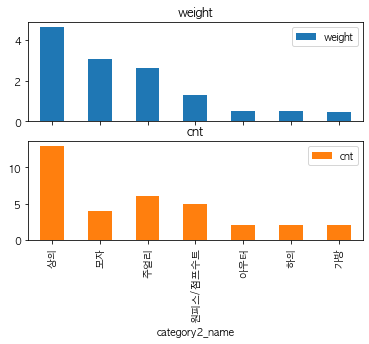

In [7]:
from matplotlib import rc
rc('font', family='AppleGothic')

df.plot.bar(x='category2_name', y=['weight', 'cnt'], subplots=True)

## Set Bins

In [10]:
total_bin = rec_size

sum = df['weight'].sum()

import math

df['bin'] = df['weight'].apply(lambda x: math.ceil(x/sum * total_bin))

df

,category2_name,weight,cnt,bin
0,상의,4.636059,13,8
1,모자,3.046864,4,5
2,주얼리,2.615619,6,5
3,원피스/점프수트,1.282141,5,2
4,아우터,0.512856,2,1
5,하의,0.489249,2,1
6,가방,0.461571,2,1


## Select items according to bin sizes

In [22]:
bin_caps = df.set_index('category2_name')['bin'].to_dict()

rec_result = []

bin_filled = {}
total_filled = 0

for r in rec_cands:
    cat = r['category2_name']

    cap = bin_caps.get(cat, 0)
    filled = bin_filled.get(cat, 0)

    if filled >= cap:
        continue

    filled += 1
    bin_filled[cat] = filled

    rec_result.append(r)

    total_filled += 1

    if total_filled > rec_size:
        break;
        
displayItemInRows(rec_cands[:rec_size])
displayItemInRows(rec_result)

# Weighted Random Choices

In [27]:
import numpy as np

weights = []
w_sum = 0.0
for c in rec_cands:
    score = c['score']
    w_sum += score
    weights.append(score)

weights = [w/w_sum for w in weights]

rec_chosen1 = np.random.choice(rec_cands, size = rec_size, replace = False, p = weights)
rec_chosen2 = np.random.choice(rec_cands, size = rec_size, replace = False, p = weights)
rec_chosen3 = np.random.choice(rec_cands, size = rec_size, replace = False, p = weights)

displayItemInRows(rec_cands[:rec_size])
displayItemInRows(rec_chosen1)
displayItemInRows(rec_chosen2)
displayItemInRows(rec_chosen3)

# Greedy Re-ranking

### Create Similarity Dictionary

In [34]:
cand_item_nos = [r['item_no'] for r in rec_cands]
cand_item_no_str = "'" + "', '".join(cand_item_nos) + "'"

query = f'''
    select a.item_no a_item_no, b.item_no b_item_no, sum(a.w*b.w) sim
    from cmc_user_product_click_w a join cmc_user_product_click_w b on a.user_no = b.user_no and a.item_no != b.item_no
    where a.item_no in ({cand_item_no_str}) and b.item_no in ({cand_item_no_str})
    group by a.item_no, b.item_no
    order by a.item_no, b.item_no
    '''

sim_result = executeQuery(query)

def make_sim_key(a, b):
    return ':'.join([a, b]) if a < b else ':'.join([b, a])

sim_dic = {}
for r in sim_result:
    a_item_no = r['a_item_no']
    b_item_no = r['b_item_no']
    sim = r['sim']

    sim_key = make_sim_key(a_item_no, b_item_no)

    sim_dic[sim_key] = sim


{'/+dRxpL8trcHld7BkWwgBA==:B5bp2zFBZbLMO02MgrYl6w==': 0.012528502728116224,
 '/+dRxpL8trcHld7BkWwgBA==:KHAovmWnnGPgJ4xc/X8LWA==': 0.19999999999999998,
 '/+dRxpL8trcHld7BkWwgBA==:KLl9xJGkbLnDwmIc5fSZ5Q==': 0.010448773587432571,
 '/+dRxpL8trcHld7BkWwgBA==:QHFx2LABqQyxs2oZqnqoyA==': 0.0559698964231797,
 '/+dRxpL8trcHld7BkWwgBA==:RBm42X6EPR25ERPNqEj5mA==': 0.19999999999999998,
 '/+dRxpL8trcHld7BkWwgBA==:TIIIyKH3bqi+6VaEdjNkzw==': 0.19999999999999998,
 '/+dRxpL8trcHld7BkWwgBA==:Y6x8DIBpzTORU8gJf+29ig==': 0.009205323272185258,
 '/+dRxpL8trcHld7BkWwgBA==:aWj7pZmZ/uSuFUAfsa9YYw==': 0.19999999999999998,
 '/+dRxpL8trcHld7BkWwgBA==:eVwFFTAMcCmCbPucn8wyyw==': 0.012528502728116224,
 '/+dRxpL8trcHld7BkWwgBA==:mA9vFqAzJ5Lng5XXzunakA==': 0.009579923056125102,
 '/+dRxpL8trcHld7BkWwgBA==:zSj8Nu7/v4NtPT1f8VwM2Q==': 0.008081886008472126,
 '/3Wvvv8GhTf5bOPKhs8wuw==:2AmJgXyJXsjaqr27jy08UA==': 0.19999999999999998,
 '/3Wvvv8GhTf5bOPKhs8wuw==:CtKP2kD+L0qyDsEoRYWAZQ==': 0.06666666666666665,
 '/3Wvvv8GhTf5bOPKhs

### Reranking

In [38]:
rec_result = []
temp_cands = list(rec_cands)

wa = 0.7
wb = 1.0 - wa
for i in range(0, rec_size):
    if len(rec_result) == 0:
        chosen = temp_cands[0]
    else: 
        for rc in temp_cands:
            rc['new_socre'] = 0
            diversity = 0
            r_cnt = 0
            for rr in rec_result:
                diversity += 1.0 - sim_dic.get(make_sim_key(rc['item_no'], rr['item_no']), 0)
                r_cnt += 1
            rc['diversity'] = diversity / r_cnt
            rc['new_score'] = wa * rc['score'] + wb * rc['diversity']

        rec_sorted = sorted(temp_cands, key=lambda r: -r['new_score'])
        chosen = rec_sorted[0]

    rec_result.append(chosen)
    temp_cands.remove(chosen)

displayItemInRows(rec_cands[:rec_size])
displayItemInRows(rec_result)